# Apply LASSO model

In [1]:
import requests
import io
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Correlation between histone PTMs and metabolomics

First, let's load our data.

In [2]:
app_gcp = pd.read_excel(
    io="D:/Chandrasekaran/Projects/EMT/Data/Proteomics/Garcia/raw/histone-PTM-EMT.xlsx",
    sheet_name="LFC"
)

app_metabolomics = pd.read_excel(
    io="C:/Users/Scott/Desktop/application.xlsx",
    sheet_name="Log2FC"
)

In [3]:
app_gcp = app_gcp[['Single PTM', 'LFC_24', 'LFC_48']]
app_gcp = app_gcp.set_index('Single PTM')
app_gcp = app_gcp.T
app_gcp.head(3)

Single PTM,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,...,H3S28ph,H3K36me1,H3K36me2,H3K36me3,H3K56me1,H3K56me2,H3K56me3,H3K79me1,H3K79me2,H3K79ac
LFC_24,0.155593,-2.092323,0.287772,-0.357557,0.003452,-0.042854,0.757362,-0.099339,-0.007080,0.279713,...,-0.380691,-0.010528,-0.038472,-0.180321,0.0,0.017738,0.0,-0.239336,-0.540247,-0.062017
LFC_48,-0.262970,-1.383009,-1.057151,-1.472531,-0.038144,0.130709,-0.024306,-0.107917,-0.034959,0.085595,...,-0.365702,-0.128719,0.219449,-1.172673,0.0,-0.212597,0.0,0.014075,0.497883,-0.237196


In [4]:
app_metabolomics = app_metabolomics[['Compound name', '24 hours', '48 hours']]
app_metabolomics = app_metabolomics.set_index('Compound name')
app_metabolomics = app_metabolomics.T
app_metabolomics.head(3)

Compound name,1-Methylnicotinamide,10-Hydroxydecanoate,2-Deoxyribose 1-phosphate,2-Deoxyribose 5-phosphate,2-Hydroxybutyrate,2-Hydroxyglutarate,2-Hydroxyisobutyrate,2-Oxoglutarate,2-Oxoisopentanoate,"2,3-DPG",...,UDP,UDP-glucose,UDP-glucuronate,UDP-N-acetylglucosamine,UMP,Urate,Urea,UTP,Val,XMP
24 hours,0.648350,1.183867,-0.452678,0.040272,1.515536,0.518912,0.0,0.224656,0.018983,0.722190,...,0.214262,0.064724,-0.136610,0.285272,0.054890,1.043209,0.572612,-0.177705,-0.046262,0.000000
48 hours,0.793587,1.193061,0.455793,-1.156795,-0.660990,0.422370,0.0,-0.063019,-0.791557,0.480208,...,-0.443411,-0.073162,-0.357369,0.017943,-0.435983,1.192923,0.148768,0.165137,-0.189555,-0.732316


In [5]:
from scipy.stats import pearsonr

def calculate_PCC(df1: pd.DataFrame, df2: pd.DataFrame):
  """
  INPUTS:
    * df1: Pandas dataframe containing only numerical values.
    * df2: Pandas dataframe containing only numerical values.
  OUTPUT:
    * pcc: Numpy array containing pearson correlation coefficients between df1 
           and df2 columns.
    * pval: Numpy array containing p-values corresponding to PCCs.
  """
  # Initialize variables
  pcc = np.zeros((df1.shape[1], df2.shape[1]))
  pval = np.zeros((df1.shape[1], df2.shape[1]))
  
  # Compute PCCs and P-values
  i = 0
  for col1 in df1.columns:
    j = 0
    for col2 in df2.columns:
      [r, p] = pearsonr(df1[col1], df2[col2])
      pcc[i, j] = r
      pval[i, j] = p
      j += 1
    i +=1
  return pcc, pval

def two_df_correlation(df1: pd.DataFrame, df2: pd.DataFrame):
  pcc, pval = calculate_PCC(df1, df2)
  new_pcc_df = pd.DataFrame(pcc, 
                   index=df1.columns, 
                   columns=df2.columns)
  new_pval_df = pd.DataFrame(pval, 
                   index=df1.columns, 
                   columns=df2.columns)
  
  return new_pcc_df, new_pval_df


Then calculate the correlation

In [6]:
pcc, pval = two_df_correlation(app_gcp, app_metabolomics)

Because we have two data points, they are assuming values of either 1 or -1.

## 2. Map metabolomics data between CCLE and application

Here's a function that we'll be able to use to map the metabolomics data to common identifiers.

In [8]:
metaboanalyst_url = "http://api.xialab.ca/mapcompounds"
def get_query(metabolite_name: dict, metaboanalyst_url: str):
    """
    """
    headers = {
        'Content-Type': "application/json",
        'cache-control': "no-cache",
    }
    response = requests.request("POST", 
                                metaboanalyst_url, 
                                data=metabolite_name, 
                                headers=headers)
    return response
    
def generate_metabolite_map(df:pd.DataFrame, axis=0, url="http://api.xialab.ca/mapcompounds") -> pd.DataFrame:
    """
    Map the metabolite dataframe using the metaboanalyst API.
    """
    if axis == 0:
        met_list = list(df.index)
    else:
        met_list = list(df.columns)
    met_list = [re.sub(r"/`", "/'", met) for met in met_list]
    mets = ';'.join(met_list)
    payload = '{"queryList": "' + mets + '","inputType": "name"}'
    payload = payload.encode('utf-8')

    map_obj = get_query(payload, url)
    map = pd.read_json(io.StringIO(map_obj.content.decode('utf-8')))
    return map

def map_metabolites(df:pd.DataFrame, axis=0, url="http://api.xialab.ca/mapcompounds") -> pd.DataFrame:
    """
    """
    map = generate_metabolite_map(df, axis=0, url="http://api.xialab.ca/mapcompounds")
    return pd.merge(map, df, 
                    how='inner',
                    left_on="Query", right_index=True), map


Let's get the metabolomics into a suitable format.

In [9]:
map = generate_metabolite_map(app_metabolomics, axis=1)
map.head(3)

,Query,Match,HMDB,PubChem,ChEBI,KEGG,METLIN,SMILES,Comment
0,1-Methylnicotinamide,1-Methylnicotinamide,HMDB0000699,457,16797,C02918,5667,C[N+]1=CC=CC(=C1)C(N)=O,1
1,10-Hydroxydecanoate,NA,NA,NA,NA,NA,NA,NA,0
2,2-Deoxyribose 1-phosphate,Deoxyribose 1-phosphate,HMDB0001351,439287,28542,C00672,6182,OC[C@H]1OC(C[C@@H]1O)OP(O)(O)=O,1


In [10]:
app_metabolomics.columns = map.ChEBI
app_metabolomics.head(3)

ChEBI,16797,NA,28542,16132,1148,17084,50129,30915,NA,17720,...,17659,46229,17200,16264,16695,17775,16199,15713,16414,15652
24 hours,0.648350,1.183867,-0.452678,0.040272,1.515536,0.518912,0.0,0.224656,0.018983,0.722190,...,0.214262,0.064724,-0.136610,0.285272,0.054890,1.043209,0.572612,-0.177705,-0.046262,0.000000
48 hours,0.793587,1.193061,0.455793,-1.156795,-0.660990,0.422370,0.0,-0.063019,-0.791557,0.480208,...,-0.443411,-0.073162,-0.357369,0.017943,-0.435983,1.192923,0.148768,0.165137,-0.189555,-0.732316


Okay, let's repeat for the CCLE dataset.

In [11]:
basepath = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/processed/model_inputs.xlsx"
met_df = pd.read_excel(basepath, 'MET_nonsignaling', index_col=0)
met_df.head(3)

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,heptanoylcarnitine,lauroylcarnitine,myristoylcarnitine,palmitoylcarnitine,stearoylcarnitine,oleylcarnitine,arachidonyl_carnitine,sarcosine,beta-alanine,anserine
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000004,-0.113363,0.174728,0.661087,-0.370089,-0.045246,0.434350,0.174760,-0.043661,1.249415,-0.213278,...,-0.487840,0.222715,0.947898,1.162742,0.784755,0.727978,0.297024,-0.350366,-0.215865,-0.154495
ACH-000007,-0.246379,-0.277360,-0.482734,-0.143775,0.042996,-0.544958,0.215370,0.003411,-0.258807,0.060592,...,-0.129539,-0.516559,-0.514631,-0.252187,-0.198568,-0.371144,0.280362,0.039629,0.191910,0.178265
ACH-000008,-0.301735,0.424280,0.549118,-0.056079,0.612689,-0.069253,-0.286402,0.373105,0.268231,0.521923,...,-0.056436,0.233915,-0.086494,-0.137966,-0.400825,-0.259514,-0.452228,-0.038606,0.253871,-0.314390


In [12]:
ccle_map = generate_metabolite_map(met_df, axis=1)

In [13]:
ccle_map

,Query,Match,HMDB,PubChem,ChEBI,KEGG,METLIN,SMILES,Comment
0,2-aminoadipate,Aminoadipic acid,HMDB0000510,469,37024,C00956,5496,NC(CCCC(=O)O)C(=O)O,1
1,3-phosphoglycerate,3-Phosphoglyceric acid,HMDB0000807,724,17050,C00597,150,OC(COP(O)(O)=O)C(O)=O,1
2,alpha-glycerophosphate,Glycerol 3-phosphate,HMDB0000126,439162,15978,C00093,5161,C([C@H](COP(=O)(O)O)O)O,1
3,4-pyridoxate,4-Pyridoxic acid,HMDB0000017,6723,17405,C00847,239,CC1=NC=C(CO)C(C(O)=O)=C1O,1
4,aconitate,cis-Aconitic acid,HMDB0000072,643757,32805,C00417,5130,OC(=O)C\C(=C\C(O)=O)C(O)=O,1
...,...,...,...,...,...,...,...,...,...
131,oleylcarnitine,NA,NA,NA,NA,NA,NA,NA,0
132,arachidonyl_carnitine,NA,NA,NA,NA,NA,NA,NA,0
133,sarcosine,Sarcosine,HMDB0000271,1088,15611,C00213,51,CNCC(O)=O,1
134,beta-alanine,beta-Alanine,HMDB0000056,239,16958,C00099,5119,NCCC(O)=O,1


In [17]:
ccle_met = 'NAD'
np.sum(map.Match == ccle_met)
#app_metabolomics[map.loc[map.Match == ccle_met, :]['Query']]

ChEBI
24 hours
48 hours


In [16]:
remapped_df = pd.DataFrame(columns=ccle_map.Query)
for idx, ccle_met in enumerate(ccle_map.Match):
    if ccle_met in map.Match.to_list():
        if ccle_met == 'NA':
            remapped_df[ccle_map.loc[ccle_map.Match == ccle_met, 'Query'][idx]] = 0
        elif ccle_met == 'NADH':
            remapped_df[ccle_map.loc[ccle_map.Match == ccle_met, 'Query'][idx]] = app_metabolomics['NAD+']
        elif ccle_met == 'NADPH':
            remapped_df[ccle_map.loc[ccle_map.Match == ccle_met, 'Query'][idx]] = app_metabolomics['NADP+']
        else:
            remapped_df[ccle_map.loc[ccle_map.Match == ccle_met, 'Query'][idx]] = app_metabolomics[map.loc[map.Match == ccle_met, :]['Query']]
    else:
        remapped_df[ccle_map.loc[ccle_map.Match == ccle_met, 'Query'][idx]] = 0

KeyError: "None of [Index(['alpha-Aminoadipate'], dtype='object', name='ChEBI')] are in the [columns]"

In [ ]:
#remapped_df.to_csv("C:/Users/Scott/Desktop/mapped_app_metabolomics.csv", index=True)

## 3. Predict using the LASSO model

In [7]:
application_met = pd.read_csv("C:/Users/Scott/Desktop/mapped_app_metabolomics.csv", index_col=0)
application_met

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,heptanoylcarnitine,lauroylcarnitine,myristoylcarnitine,palmitoylcarnitine,stearoylcarnitine,oleylcarnitine,arachidonyl_carnitine,sarcosine,beta-alanine,anserine
24 hours,0.509673,0.618688,0.239351,0,0.216156,-0.022994,0.129087,0.224656,0.420370,0.113862,...,0,0,0,0,0,0,0,-0.750412,0,0
48 hours,0.134410,1.429310,0.119972,0,0.111125,-0.235745,-0.096311,-0.063019,0.056378,-0.082637,...,0,0,0,0,0,0,0,-0.347671,0,0


In [8]:
app_gcp = pd.read_excel(
    io="D:/Chandrasekaran/Projects/EMT/Data/Proteomics/Garcia/raw/histone-PTM-EMT.xlsx",
    sheet_name="Application",
    index_col=0
)
app_gcp

,H3K4me1,H3K4me2,H3K4ac1,H3K9me1,H3K9me2,H3K9me3,H3K9ac1,H3K14ac1,H3K18ac1,H3K23ac1,H3K36me1,H3K36me2,H3K36me3,H3K27me1,H3K27me2,H3K27me3,H3K27ac1,H3K56me1,H3K79me1,H3K79me2
LFC_24,0.155593,-2.092323,0.287772,-0.357557,0.003452,-0.042854,0.757362,-0.099339,-0.007080,0.279713,-0.010528,-0.038472,-0.180321,-0.854200,-0.035135,0.198701,0.434725,0,-0.239336,-0.540247
LFC_48,-0.262970,-1.383009,-1.057151,-1.472531,-0.038144,0.130709,-0.024306,-0.107917,-0.034959,0.085595,-0.128719,0.219449,-1.172673,-1.696381,-0.012389,0.254031,-1.533607,0,0.014075,0.497883


In [9]:
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import keras

def evaluate_models(input, output, model_loadpath:str=None, training_set=False):
    """Train LASSO models for a single- or multi-target problem."""
    predictions = list()
    all_mse = list()

    for target in output.columns:
        y = output[target].astype(float).values.astype('float32')
        X = input.values.astype('float32')
        if training_set:
            _, X, _, y = train_test_split(X, y, train_size=0.8)
            
        model = keras.models.load_model(model_loadpath+'/'+target)

        pred = model.predict(X)
        predictions.append(pred)
        all_mse.append(np.square(np.subtract(y, pred)).mean())

    return predictions, all_mse

In [10]:
predictions, all_mse = evaluate_models(
                                        input=application_met, 
                                        output=app_gcp,
                                        model_loadpath="D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/models/LASSO/met2gcp",
                                        training_set=False
                                    )

In [11]:
all_mse

[0.07653227,
 3.5918355,
 0.5604329,
 1.0352639,
 0.04356305,
 0.35271132,
 0.21092743,
 0.07384495,
 0.020950686,
 0.12794665,
 0.2819704,
 0.15051848,
 0.46029568,
 2.6781735,
 0.047262356,
 0.09770525,
 1.1896667,
 0.6483732,
 0.08614795,
 0.37214616]

In [12]:
basepath = "D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/processed/model_inputs.xlsx"
gcp_df = pd.read_excel(basepath, 'GCP_all', index_col=0)
met_df = pd.read_excel(basepath, 'MET_nonsignaling', index_col=0)

ytest_pred, ytest_mse = evaluate_models(
                 input=met_df, 
                 output=gcp_df,
                 model_loadpath="D:/Chandrasekaran/Projects/Epigenetics-Metabolism/Data/models/LASSO/met2gcp",
                 training_set=True
             )

In [13]:
ytest_mse

[0.32844037,
 0.3144507,
 1.6203355,
 0.15081422,
 0.19407704,
 0.40171656,
 0.5742547,
 0.31545675,
 0.561554,
 0.26717842,
 0.7234865,
 0.9362439,
 0.42974675,
 0.43425503,
 0.46779132,
 0.57765424,
 1.0642766,
 0.31674278,
 0.20258175,
 0.56791437]

In [14]:
mse_df = pd.DataFrame()
mse_df['PTM'] = gcp_df.columns
mse_df['Application'] = all_mse
mse_df['CCLE'] = ytest_mse
mse_df

,PTM,Application,CCLE
0,H3K4me1,0.076532,0.328440
1,H3K4me2,3.591835,0.314451
2,H3K4ac1,0.560433,1.620335
3,H3K9me1,1.035264,0.150814
4,H3K9me2,0.043563,0.194077
5,H3K9me3,0.352711,0.401717
6,H3K9ac1,0.210927,0.574255
7,H3K14ac1,0.073845,0.315457
8,H3K18ac1,0.020951,0.561554
9,H3K23ac1,0.127947,0.267178


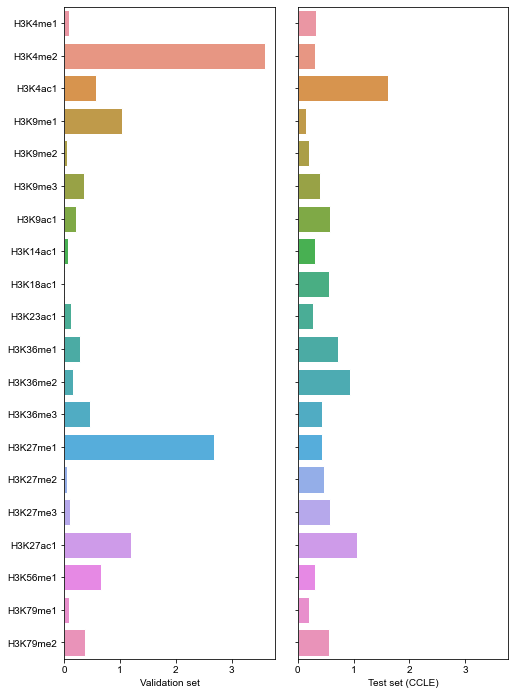

In [15]:
import seaborn as sns
_, axs = plt.subplots(figsize=(7.5, 10), ncols=2, sharey=True, sharex=True)
sns.set(font_scale=1.5)
sns.barplot(data=mse_df, y='PTM', x='Application', ax=axs[0])
sns.barplot(data=mse_df, y='PTM', x='CCLE', ax=axs[1])
axs[1].set_ylabel('')
axs[0].set_ylabel('')
axs[0].set_xlabel('Validation set')
axs[1].set_xlabel('Test set (CCLE)')
plt.tight_layout()